In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [2]:
import os
import logging
import warnings as wr
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as tfk
from keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [3]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

In [5]:
!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz

--2023-11-11 17:19:21--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 74.125.143.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229962973 (219M) [application/octet-stream]
Saving to: ‘public_data_clean_balanced_splitted.npz’

public_data_clean_b 100%[===================>] 219.31M  23.5MB/s    in 9.3s    

2023-11-11 17:19:30 (23.5 MB/s) - ‘public_data_clean_balanced_splitted.npz’ saved [229962973/229962973]



In [6]:
X_train_val, y_train_val, X_test, y_test = np.load('public_data_clean_balanced_splitted.npz', allow_pickle=True).values()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

In [7]:
def mix_up(X_train, y_train, to_generate):
  y_train = y_train.astype("float32")
  inserted_elements = 0
  tot_elements = len(y_train) -1
  while(True):
    index_1 = rnd.randint(inserted_elements, tot_elements)
    index_2 = rnd.randint(inserted_elements, tot_elements)
    gamma1 = np.random.gamma(0.2)
    gamma2 = np.random.gamma(0.2)
    beta = gamma1/ (gamma1 + gamma2)
    new_image = X_train[index_1] * beta + X_train[index_2] * (1-beta)
    new_label = y_train[index_1] * beta + y_train[index_2] * (1-beta)
    X_train = np.insert(X_train, 0, new_image, axis = 0)
    y_train = np.insert(y_train, 0, new_label, axis = 0)
    inserted_elements += 1
    tot_elements += 1
    if inserted_elements >= to_generate:
      break

  return X_train, y_train


X_train, y_train = mix_up(X_train, y_train, 4000)

In [8]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  preprocessing = tfk.Sequential([
      # tkl.RandomContrast(factor=(0,0.3)),
      # tkl.RandomBrightness(factor=(0,0.3)),
      tfkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
      tfkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
      tfkl.RandomFlip('horizontal'),
      tfkl.RandomRotation(factor=359)
    ], name='preprocessing'
  )

  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  res.trainable = False
  input_layer = tfkl.Input(input_shape)

  # x = data_rescaling_c(input_layer)
  x = preprocess_input(input_layer)
  #x = preprocessing(x)
  x = res(x)
  x = tfkl.GlobalAveragePooling2D()(x)
  x = tfkl.Dense(units=128,activation=tfkl.LeakyReLU(alpha=0.3))(x)      # maybe we have to use leakyrelu
  x = tfkl.Dropout(0.7)(x)

  # x = tkl.Dense(units=2048,activation='relu')(x)
  # x = tkl.Dense(units=2048,activation='relu')(x)
  # x = tkl.Dense(units=1024,activation='relu')(x)

  output_layer = tfkl.Dense(units=output_shape,activation='softmax')(x)
  model =tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

model = apple_elixir_model(input_shape,output_shape)

In [9]:
EPOCHS = 200


# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/200
170/170 [==============================] - 70s 250ms/step - loss: 0.8893 - accuracy: 0.5838 - val_loss: 0.6244 - val_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 2/200
170/170 [==============================] - 27s 158ms/step - loss: 0.6808 - accuracy: 0.6580 - val_loss: 0.5684 - val_accuracy: 0.6940 - lr: 1.0000e-04
Epoch 3/200
170/170 [==============================] - 28s 163ms/step - loss: 0.6396 - accuracy: 0.6768 - val_loss: 0.4837 - val_accuracy: 0.7606 - lr: 1.0000e-04
Epoch 4/200
170/170 [==============================] - 26s 155ms/step - loss: 0.6013 - accuracy: 0.7012 - val_loss: 0.4798 - val_accuracy: 0.7682 - lr: 1.0000e-04
Epoch 5/200
170/170 [==============================] - 27s 159ms/step - loss: 0.5830 - accuracy: 0.7098 - val_loss: 0.5104 - val_accuracy: 0.7362 - lr: 1.0000e-04
Epoch 6/200
170/170 [==============================] - 29s 170ms/step - loss: 0.5689 - accuracy: 0.7224 - val_loss: 0.4799 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 7/200
170/170 [=

In [10]:
NAME_MODEL = "ConvNeXtCV_001"
NAME_PLOT = NAME_MODEL + "_plot"

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.8399
Precision: 0.8416
Recall: 0.8399
F1: 0.8397


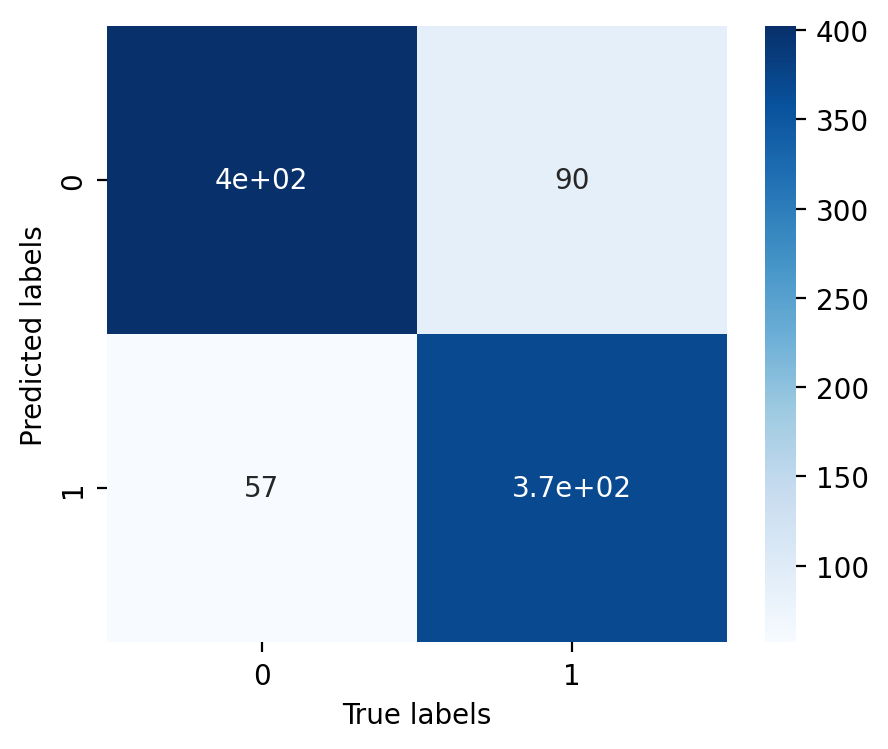

In [12]:
# Compute the confusion matrix
test_predictions = model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [13]:
model.save(NAME_MODEL)
del model

In [14]:
ft_model = tfk.models.load_model(NAME_MODEL)

In [15]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print(c)

295


In [16]:
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001), metrics=['accuracy'])

In [17]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor (validation mean squared error in this case)
    patience=5,                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/200
170/170 [==============================] - 116s 343ms/step - loss: 0.4421 - accuracy: 0.7952 - val_loss: 0.3515 - val_accuracy: 0.8412 - lr: 1.0000e-04
Epoch 2/200
170/170 [==============================] - 44s 258ms/step - loss: 0.3768 - accuracy: 0.8312 - val_loss: 0.3363 - val_accuracy: 0.8502 - lr: 1.0000e-04
Epoch 3/200
170/170 [==============================] - 44s 258ms/step - loss: 0.3576 - accuracy: 0.8491 - val_loss: 0.2628 - val_accuracy: 0.8873 - lr: 1.0000e-04
Epoch 4/200
170/170 [==============================] - 43s 252ms/step - loss: 0.3159 - accuracy: 0.8688 - val_loss: 0.2556 - val_accuracy: 0.8822 - lr: 1.0000e-04
Epoch 5/200
170/170 [==============================] - 44s 256ms/step - loss: 0.2998 - accuracy: 0.8790 - val_loss: 0.2577 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 6/200
170/170 [==============================] - 44s 258ms/step - loss: 0.2760 - accuracy: 0.8901 - val_loss: 0.2399 - val_accuracy: 0.8924 - lr: 1.0000e-04
Epoch 7/200
170/170 [

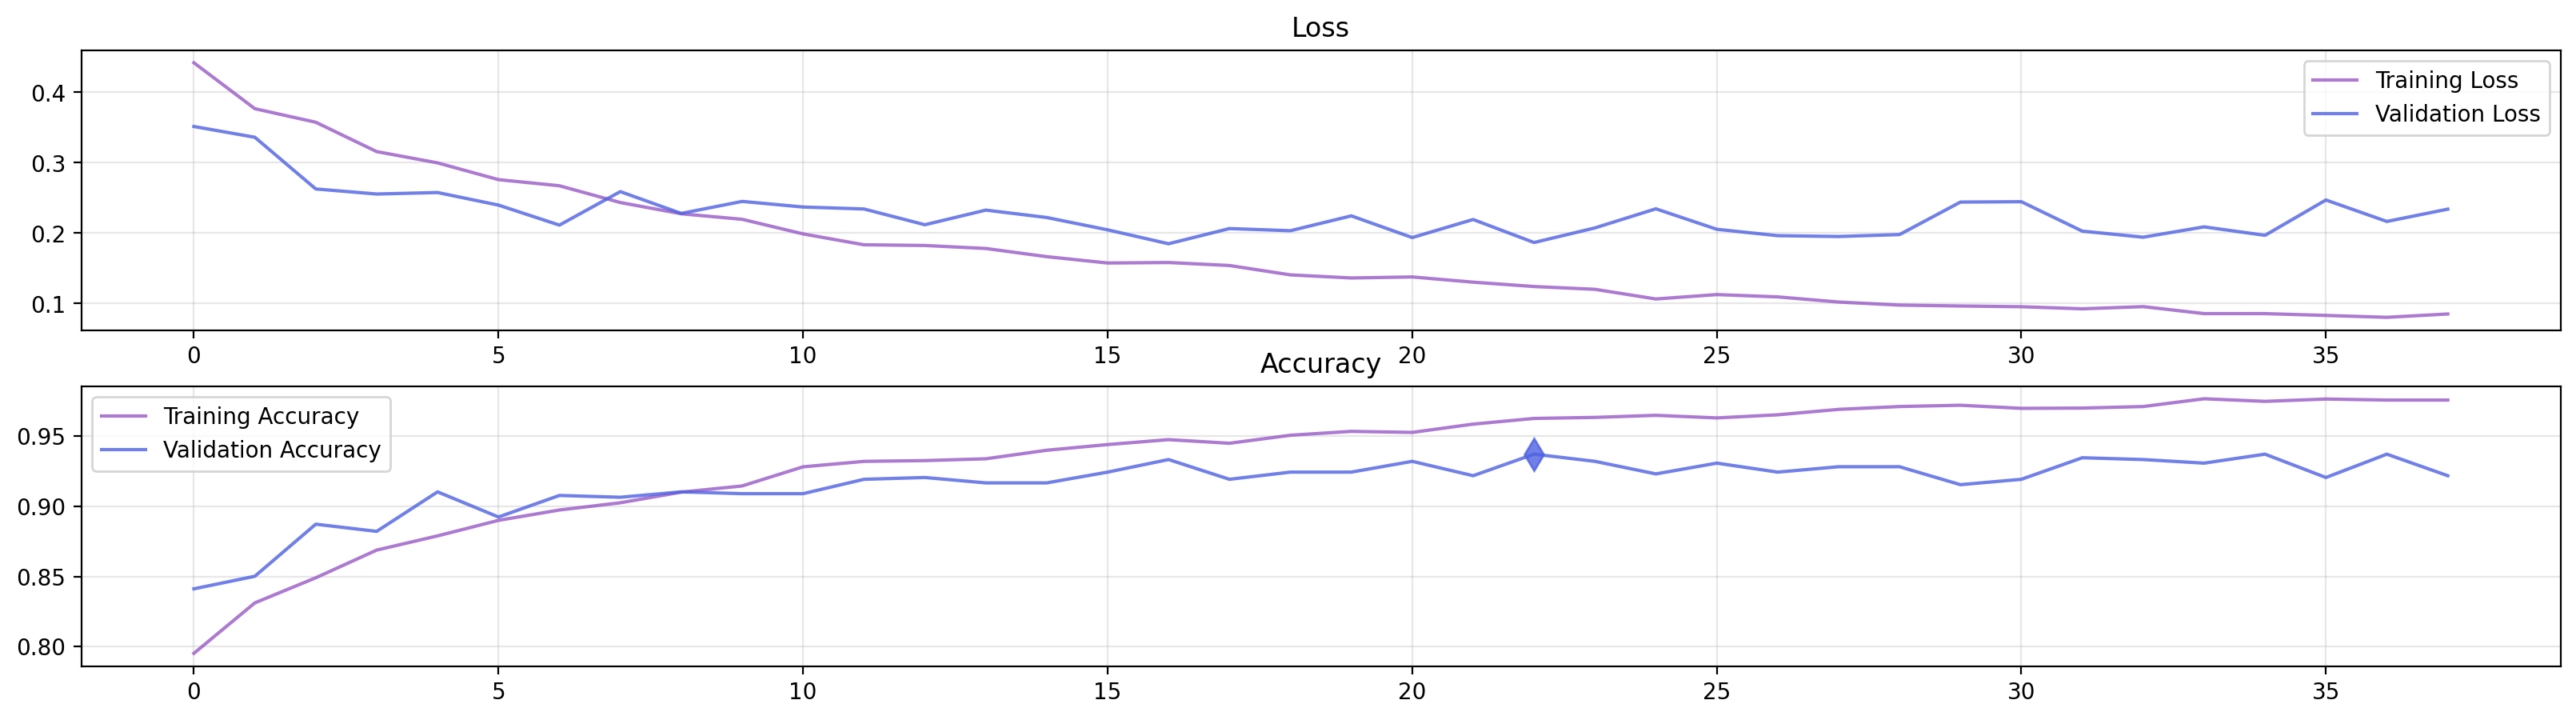

Accuracy Score over the Test Set: 0.9314



In [18]:
plot_losses(history, (20,5), NAME_PLOT)

test_predictions = ft_model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.9314
Precision: 0.9315
Recall: 0.9314
F1: 0.9314


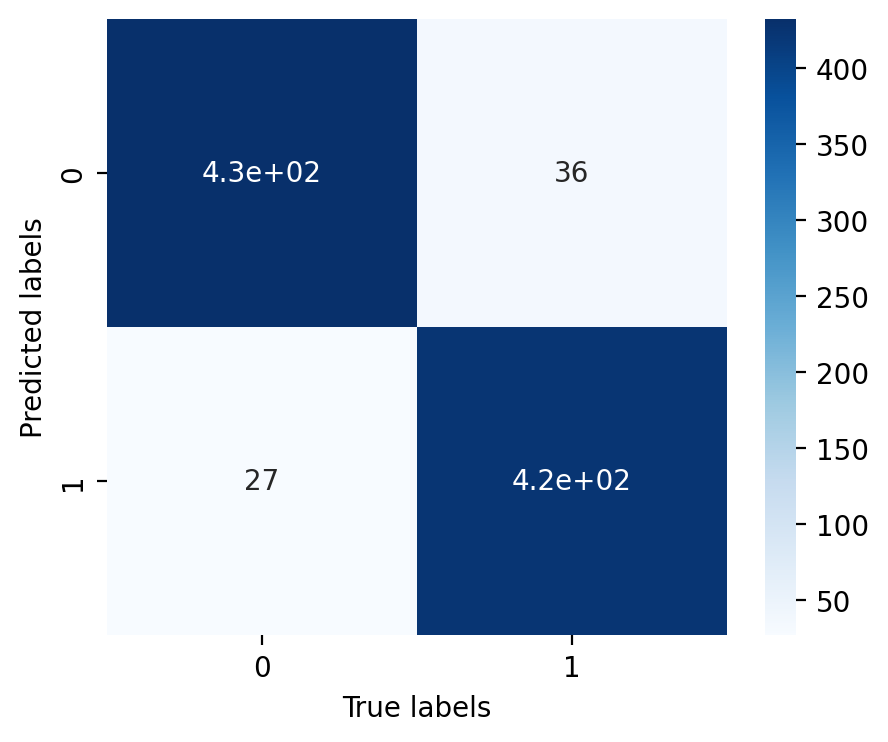

In [19]:
# Compute the confusion matrix
test_predictions = ft_model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [20]:
ft_model.save(NAME_MODEL)

In [21]:
ft_model.save('/gdrive/My Drive/MixUp_ConvNeXt_2')